Raw data shape: (100000, 18)

First 5 rows:
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794 

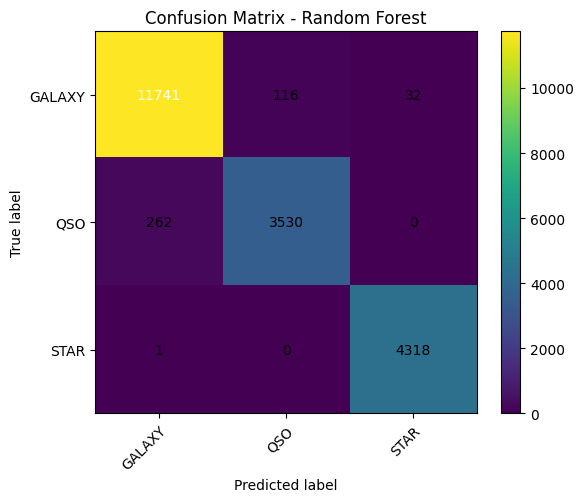


Top 10 most important features:
    feature  importance
7  redshift    0.609633
6         z    0.092137
3         g    0.077778
2         u    0.074362
5         i    0.070517
4         r    0.049215
0     alpha    0.013767
1     delta    0.012591


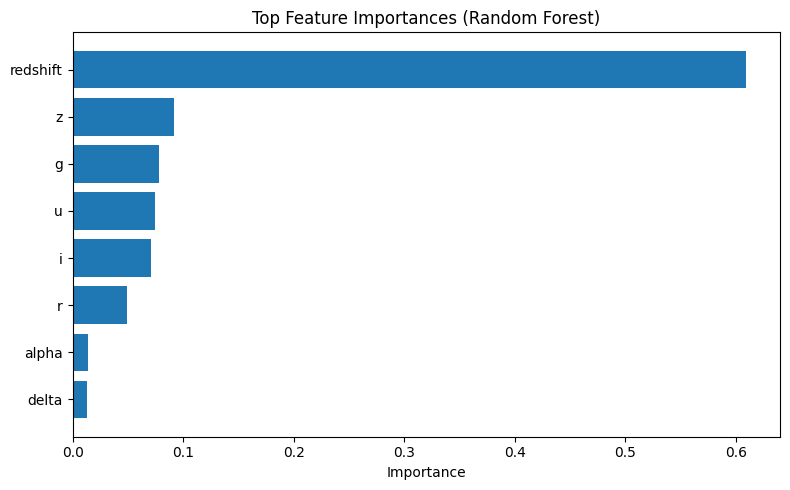


Number of misclassified samples: 411

Five misclassified examples:
            alpha      delta         u         g         r         i  \
83052  355.434486  18.409252  22.29067  22.58921  22.18496  22.00596   
11909  178.994258  -3.562566  18.44375  17.53037  17.31466  17.31782   
29204   22.183747   4.450217  23.54034  22.08017  21.74554  21.58752   
22850  130.762563  23.498424  22.09398  21.70409  21.60573  21.72319   
17797  189.575880  56.180069  22.45733  23.30622  21.37446  20.34853   

              z  redshift true_label pred_label  correct  
83052  21.52744  1.052249        QSO     GALAXY    False  
11909  18.75798  0.757313     GALAXY        QSO    False  
29204  21.36760  1.786434     GALAXY        QSO    False  
22850  21.26084  1.404986     GALAXY        QSO    False  
17797  19.48138  0.899533        QSO     GALAXY    False  

Saved 5 misclassified samples to 'misclassified_samples_top5.csv'
Saved full test predictions to 'test_predictions_with_labels.csv'

Class propo

In [ ]:
"""
Star / Galaxy / QSO Classification using Supervised Learning

- Dataset: star_classification.csv (e.g., SDSS-based catalog)
- Goal: Predict the object class (STAR, GALAXY, QSO) from photometric & related features
- Model: RandomForestClassifier (multiclass classification)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)


# 1. CONFIG & DATA LOADING

DATA_PATH = Path("star_classification.csv")  
df = pd.read_csv(DATA_PATH)

print("Raw data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nClass distribution:")
print(df["class"].value_counts())
print("\nAny missing values?")
print(df.isna().sum())

# 2. BASIC CLEANING & FEATURE SETUP

# Columns that are identifiers or not meaningful for prediction
ID_COLUMNS = [
    "obj_ID",
    "spec_obj_ID",
    "run_ID",
    "rerun_ID",
    "cam_col",
    "field_ID",
    "plate",
    "MJD",
    "fiber_ID",
]

data = df.copy()
data = data.drop(columns=ID_COLUMNS)
data = data.dropna()

print("\nCleaned data shape:", data.shape)

TARGET_COL = "class"
y = data[TARGET_COL]
X = data.drop(columns=[TARGET_COL])

print("\nFeatures:")
print(X.columns.tolist())

# 3. TRAIN / TEST SPLIT (SUPERVISION)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)

# 4. MODEL: RANDOM FOREST

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  
)

rf_model.fit(X_train, y_train)

# 5. EVALUATION

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n=== RANDOM FOREST PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
print("Confusion Matrix (raw counts):")
print(cm)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix - Random Forest")
plt.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(rf_model.classes_)))
ax.set_yticks(np.arange(len(rf_model.classes_)))
ax.set_xticklabels(rf_model.classes_)
ax.set_yticklabels(rf_model.classes_)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.savefig("confusion_matrix_rf.png", dpi=300)
plt.show()

# 6. FEATURE IMPORTANCE (INSIGHTS)

importances = rf_model.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 10 most important features:")
print(fi_df.head(10))

TOP_N = 10
top_fi = fi_df.head(TOP_N)
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_fi["feature"][::-1], top_fi["importance"][::-1])
ax.set_title("Top Feature Importances (Random Forest)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance_rf.png", dpi=300)
plt.show()


# 7. FIND MISCLASSIFIED SAMPLES

results_df = X_test.copy()
results_df["true_label"] = y_test.values
results_df["pred_label"] = y_pred
results_df["correct"] = results_df["true_label"] == results_df["pred_label"]

mistakes = results_df[~results_df["correct"]]

print("\nNumber of misclassified samples:", len(mistakes))

mistakes_head = mistakes.head(5)
print("\nFive misclassified examples:")
print(mistakes_head)

mistakes_head.to_csv("misclassified_samples_top5.csv", index=False)
print("\nSaved 5 misclassified samples to 'misclassified_samples_top5.csv'")

results_df.to_csv("test_predictions_with_labels.csv", index=False)
print("Saved full test predictions to 'test_predictions_with_labels.csv'")

# 8. SIMPLE SUMMARY TABLES

overall_class_dist = y.value_counts(normalize=True).rename("overall_prop")
train_class_dist = y_train.value_counts(normalize=True).rename("train_prop")
test_class_dist = y_test.value_counts(normalize=True).rename("test_prop")

dist_table = pd.concat([overall_class_dist, train_class_dist, test_class_dist], axis=1)
print("\nClass proportion table (overall / train / test):")
print(dist_table)

dist_table.to_csv("class_proportions.csv")

cols_to_show = ["u", "g", "r", "i", "z", "alpha", "delta", "true_label", "pred_label"]
print("\nMisclassified samples (selected columns):")
print(mistakes_head[cols_to_show])
